# IA Paper 2 - Structures - Examples paper 4

On this examples papers the bending moment and shear forces are calculated for different types of beam and load configurations. Develop Python code to calculate bending moments, shear forces and displacement for cantilever and simply supported beams for different load configurations.

## Guidelines

First, we import the required Python modules - `numpy` for numerical calculation and `matplotlib` for plotting.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

We first initialise our beam parameters:

In [3]:
# Generate load profile of a beam
# Beam parameters, [units]
span = (0, 4)        # [m]
width = 0.5          # [m]
thick = 0.5          # [m]
E = 9e9              # [Pa]

We will evaluate quantities at points along the beam. We create an array `x` to hold points along the beam:

In [4]:
n = 100
x = np.linspace(span[0], span[1], n)

What we need next is to create a load configuration on the beam. Students are advised to amend the following codes to match with the provided loading configuration that is provided in the example paper. 

First, we define our distributed load. Here, we assume that our distributed load is as followed:

$$
q(x) = -x^2
$$

In [5]:
# Distributed load: column vector [position,load]
def distributed_load(x):
    # return 0.0
    # STUDENTS: Try different distributed loads
    return -x**2

On top of our distributed load, the following code illustrates how to add a point load. Along the span of $4$ m, we assume that there are point loads at positions $x = 1.0$ m and $x = 3.0$ m, with magnitudes of $1$ N and $3$ N, respectively. 

In order to apply point loads, we need to first find the element in our `numpy` array `x` that corresponds to where the point load is applied. Due to the way that `x` is discretised, it is sometimes not possible to find the exact values of `1.0` and `3.0` in the array. Instead, we look for the elements in `x` that are `closest` to our desired values. The following function `find_nearest` looks for the index - `idx` in the `array` that is closest to the input `value`.

In [6]:
def find_nearest(array, value):
    idx = (np.abs(array - value)).argmin()
    return idx

Our `point_load` has the following data structure: each point load is stored as a row in a two-column matrix. The first entry of the row indicate where along the span, i.e. among the `x` array, the point load is applied, and second entry shows the magnitude of the point load.

In [7]:
def load_configuration(x):
    "Load profiles along beam"
    # FOR STUDENTS: CHANGE THE CODE FOR THE CORRESPONDING
    # PROFILE IN THE EXAMPLE PAPER
    load = np.zeros(len(x))
    dx = x[1] - x[0]

    # Position needs to coincide with a value of x
    # [[position1,load1],
    # [position2,load2],...]
    point_load = np.array([[1.0, 1.0],
                           [3.0, 3.0]])    # [N]

    for i in range(point_load.shape[0]):
        j = find_nearest(x, point_load[i, 0])
        load[j] = point_load[i, 1]

    # select over which beam section the distributed load
    # is applied
    for i in range(len(x)):
        if x[i] >= 0 and x[i] <= 4:
            load[i] = load[i] + distributed_load(x[i])

    return load

Let's have a look at our load configuration here. It is expected that the following load configuration does not match any given question in the example paper - students are advised to edit the code to achieve the corresponding results. 

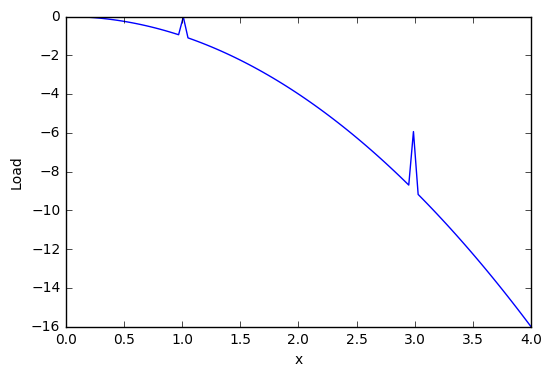

In [8]:
# Obtain and plot the load profile
load = load_configuration(x)
plt.plot(x, load)
plt.xlabel('x')
plt.ylabel('Load');

Next we need the Young's modulus (`E`) and the moment of inertia of the beam (`I`). Here we just assume that `I` is constant along the `x` direction, but this is not always the case. We can write extra function to generate a varying `I` as a function of `x`, and this is saved for those who are curious. For a beam of rectangular cross section with width $b$ and thickness $t$, the bending moment of inertia is:

$$
I = \dfrac{bt^3}{12}
$$

In [9]:
# Define I
I = width*(thick**3)/12    #[m^4]

To achieve a specific solution from a given loading configuration, boundary conditions are required. For a **cantilever beam** the boundary conditions are:

\begin{align}
    v(0) &= 0, \\
    \dfrac{dv}{dx}\Bigr|_{x=0} &= 0, \\
    M(0) &= \int_0^L w(x) x dx, \\
    S(0) &= - \int_0^L w(x) dx
\end{align}

while for a **simply supported beam**:

\begin{align}
    v(0) &= 0, \\
    \dfrac{dv}{dx}\Bigr|_{x=0} &= -\int_0^L \dfrac{wb}{6L}(L^2 - b^2)
\end{align}

where $b = L- x$, and

\begin{align}
    M(0) &= 0, \\
    S(0) &= - \int_0^L w(x) dx + F(L)
\end{align}

Here, $w$ is the applied load, $S$ is the shear force, $M$ is the bending moment, $v$ is the beam displacement and $x$ is the coordinate along the beam. 

Before applying these specific boundary condition, we need to initilise empty arrays for these values, using `np.zeros()`. The code provided below illustrates the function where the boundary conditions are applied for each case - cantilever or simply supported beam. To evaluate the integral, we can simply sum-up our vector using `np.sum()`. Let's look at a specific example. Suppose we want to evaluate:

$$
S(0) = - \int_0^L w(x) dx
$$

we can simply write:
```python
shear[0] = -np.sum(load)*dx
```

The full function is provided below. 

In [10]:
def init_struct(bc_type, load, x, E, I):
    "Get array and boundary condition for beam bending problem"
    # Get the length of the x-array
    n = len(x)
    dx = x[1] - x[0]

    # Generate empty arrays for shear, moment, slope and deflection
    F = np.zeros(n)
    M = np.zeros(n)
    alpha = np.zeros(n)
    y = np.zeros(n)

    # Catilever vs simply supported beam
    if bc_type is 'cantilever':
        # Shear force - Boundary condition at x=0
        F[0] = -np.sum(load)*dx

        # Moment - Boundary condition at x=0
        M[0] = np.sum((x*load))*dx

        # Slope - Boundary condition at x=0
        alpha[0] = 0

        # Deflection - Boundary condition at x=0
        y[0] = 0

    elif bc_type is 'supported':
        # Shear force
        force_b = np.sum((x*load))*dx/x[-1]  # force at x=L; since m[0]=0
        F[0] = -np.sum(load)*dx + force_b  # boundary conditions at x=0

        # Bending moment - Boundary condition at x=0
        M[0] = 0

        # Slope - Boundary condition at x=0
        for i in range(n-2):
            alpha[0] = alpha[0] - load[n-i-1]*x[i+1] *\
                (x[-1]**2 - x[i+1]**2)/(6*x[-1])*dx
        alpha = alpha/(E*I)

        # Deflection - Boundary condition at x=0
        y[0] = 0

    return F, M, alpha, y

Having defined our boundary condition, we can now use the following differential equations for our beam deflections (see also Structures Data Book):

$$
\begin{aligned}
w &= \dfrac{dS}{dx}, \\
S &= \dfrac{dM}{dx}, \\
M &= -EI\dfrac{d^2 v}{dx^2} \\
\end{aligned}
$$

We can integrate these equations to, eventually, arrive at the displacement, coupling with our defined boundary conditions. Let's look at, again, another simple example. Say we want to evaluate the shear force $S$ along the beam knowing the load $w$ using:

$$
w = \dfrac{dS}{dx}
$$

For the code:

```python
# Shear force
for i in range(1, n):
    S[i] = S[i-1] + w[i-1]*dx
```

The function that is used for calculating the shear force, bending moment, slope, curvature and deflection is provided below. It is pretty much self-explaintory, with comments are provided where necessary. 

In [11]:
def calculating_struct(load, x, E, I_inp, bc_type):
    "Solving the beam bending problem"
    # Get the length of the x-array
    n = len(x)
    dx = x[1] - x[0]

    # Convert a single value moment of area into an array
    # of same length of x
    # This allows to treat constant I and variable I cases
    # with the same code further down
    if np.size(I_inp) < np.size(x):
        I = I_inp*np.ones(n)
    else:
        I = I_inp

    # Initiliase array and boundary condition
    F, M, alpha, y = init_struct(bc_type, load, x, E, I)

    # Shear force
    for i in range(n-1):
        F[i + 1] = F[i] + load[i]*dx

    # Bending moment
    for i in range(n-1):
        M[i + 1] = M[i] + F[i]*dx

    # Slope, which is dv/dx
    for i in range(n-1):
        alpha[i + 1] = alpha[i] - M[i]/(E*I[i])*dx

    # Curvature, which is -dv^2/dx^2
    curv = np.zeros(n)
    curv = M/(E*I)

    # Deflection
    for i in range(n-1):
        y[i + 1] = y[i] + alpha[i]*dx

    return F, M, alpha, curv, y

Let's get our results and plot them. First, let's look at the cantilever case. 

In [12]:
# Get the results for the cantilever
shear, moment, slope, curvature, deflection = \
    calculating_struct(load, x, E, I, 'cantilever')

Now let's examine the results on graph. Here we only plot the deflection, bending moment and the shear force. 

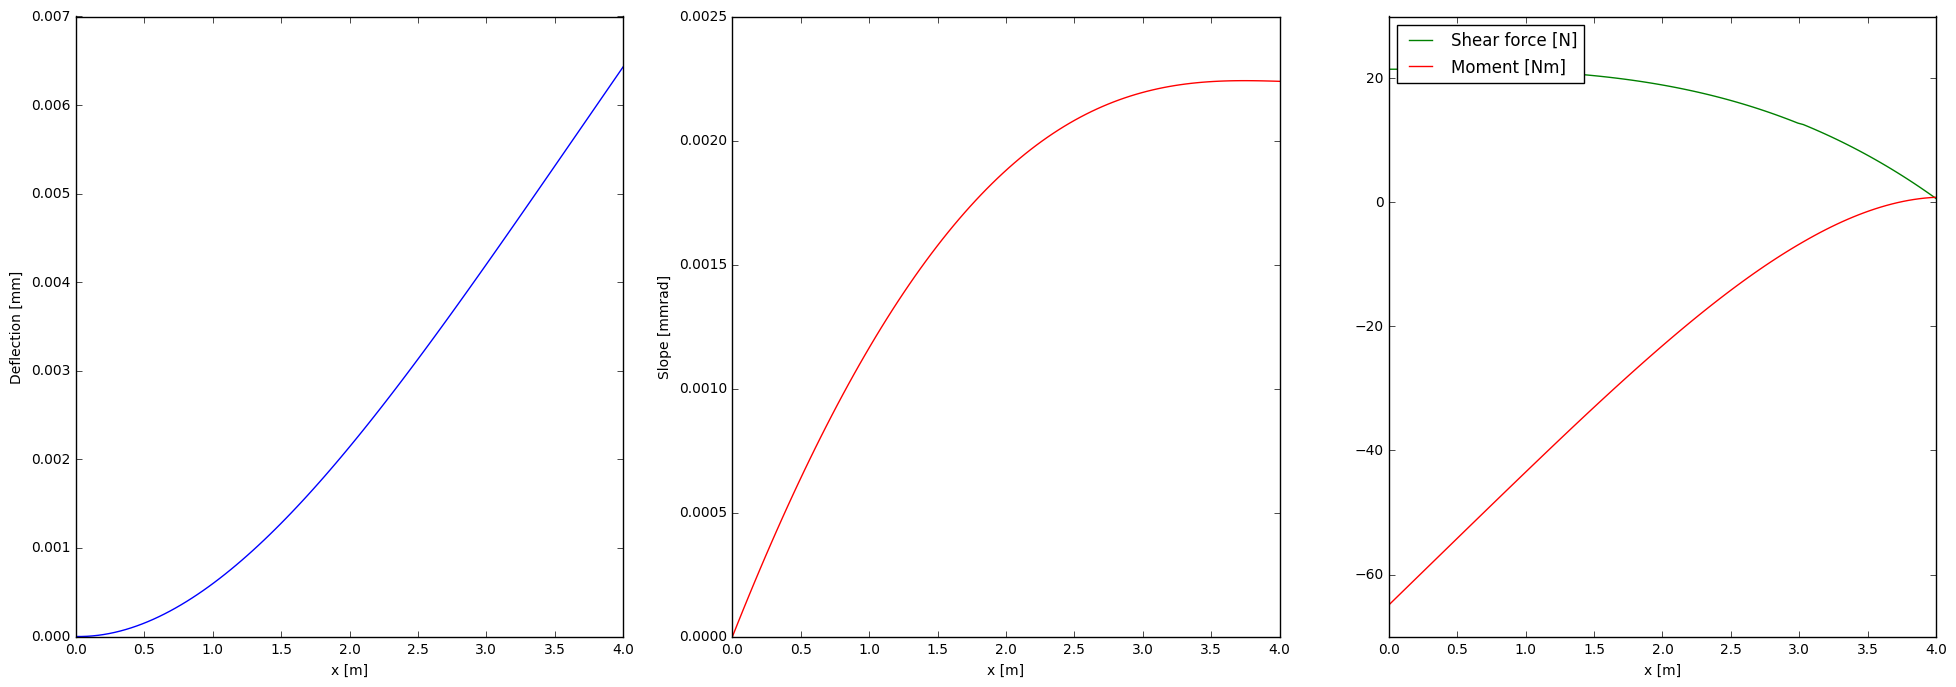

In [13]:
# Initlise the figure and the subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

# Plot the deflection
ax1.plot(x, deflection*1e3)
ax1.set_xlabel('x [m]')
ax1.set_ylabel('Deflection [mm]')

# Plot the slope along the beam
ax2.plot(x, slope*1e3, 'r')
ax2.set_xlabel('x [m]')
ax2.set_ylabel('Slope [mmrad]')

# Plot the shearforce
ax3.plot(x, shear, 'g', label='Shear force [N]')
ax3.plot(x, moment, 'r', label='Moment [Nm]')
ax3.set_xlabel('x [m]')
ax3.legend(loc=2);

Now the simply-supported case. 

In [14]:
# Get the results for the cantilever
shear, moment, slope, curvature, deflection = \
    calculating_struct(load, x, E, I, 'supported')

And again, let's check the plots.

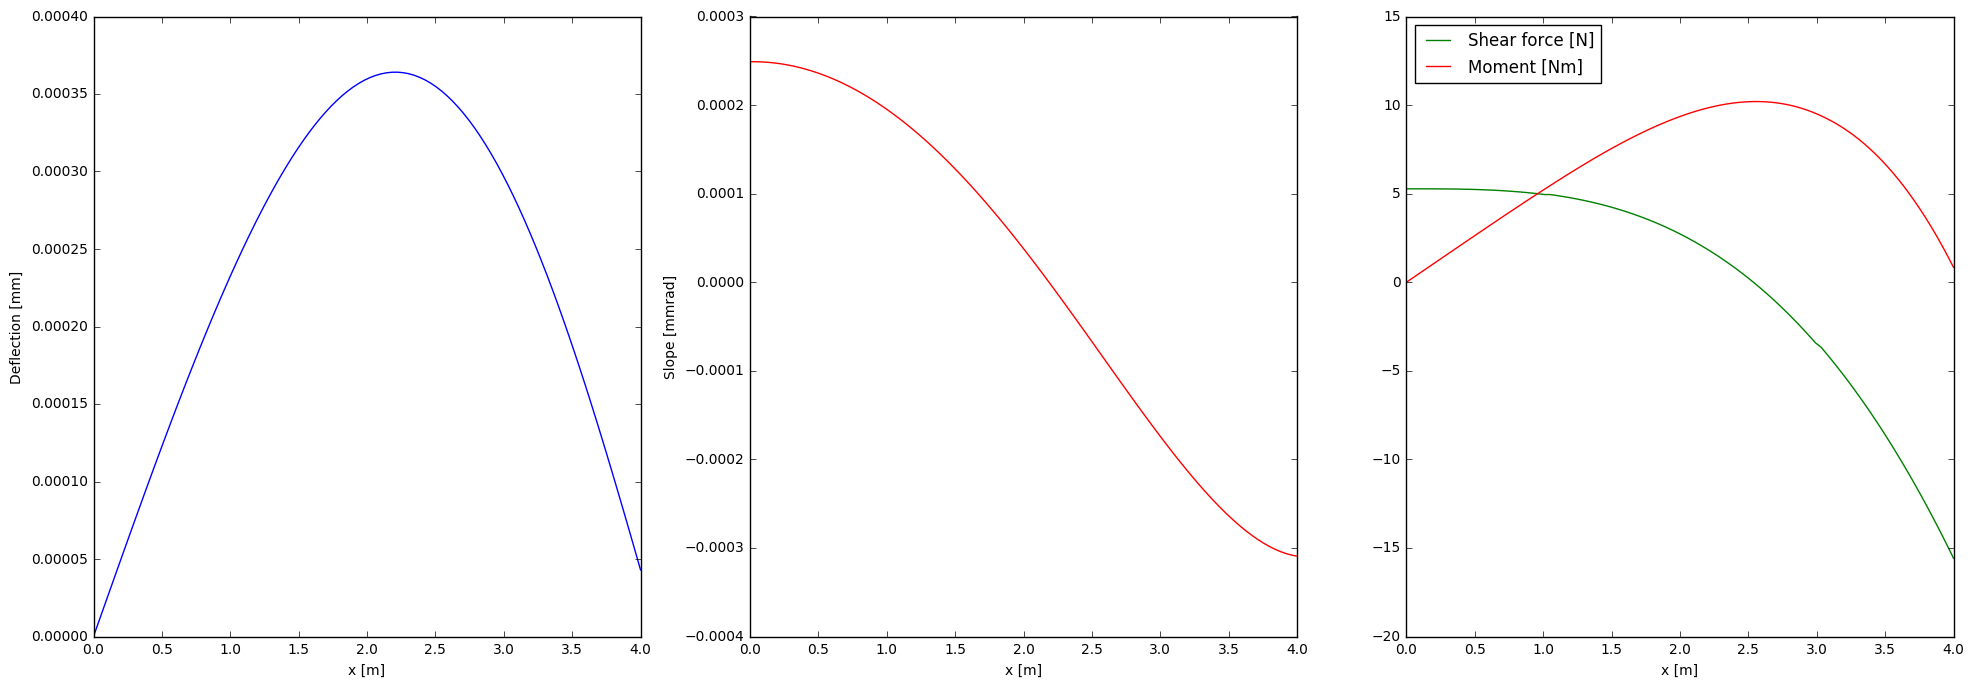

In [15]:
# Initlise the figure and the subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

# Plot the deflection
ax1.plot(x, deflection*1e3)
ax1.set_xlabel('x [m]')
ax1.set_ylabel('Deflection [mm]')

# Plot the slope along the beam
ax2.plot(x, slope*1e3, 'r')
ax2.set_xlabel('x [m]')
ax2.set_ylabel('Slope [mmrad]')

# Plot the shearforce
ax3.plot(x, shear, 'g', label='Shear force [N]')
ax3.plot(x, moment, 'r', label='Moment [Nm]')
ax3.set_xlabel('x [m]')
ax3.legend(loc=2);

## Extra: Modelling an aircraft wing

The following code solves for the bending of an air craft wing is calculated. The codes calculates the wing and fuel load as well as the lift along the wing and then
uses our code for the cantilever to calculate the bending moment, shear force and deflection. 

In [16]:
# Aircraft parameters
w_total = 4800     # Total weight
w_wing = 630       # Weight of wings
w_fuel = 675       # Weight of fuel

l_wing = 7         # Length of wing
l_tank = 4.8       # Length of fuel tank
c_wing_0 = 1.8     # Chord length at wing root
c_wing_t = 1.4     # Chord length at wing tip
c_tank_0 = 1.4     # Width of fuel tank at wing root
c_tank_l = 0.85    # Width of fuel tank at l_tank
h_wing = 0.5       # Thickness of wing
t_skin = 0.01      # Thickness of wing spars
E = 9e9  # Young's modulus of aluminium [Pa]

In [17]:
# Load factor, =1 for level flight, 1.5 for climb
load_factor = 1.5

# x position along wing, note transpose
x = np.linspace(0, l_wing, 100)
dx = x[1] - x[0]

In [18]:
# Define anonymous functions for

def lift_profile(x, n):
    "Lift profile"
    global w_total, l_wing
    return -2*w_total*n / (np.pi*(l_wing**2))*np.sqrt(l_wing**2 - x**2)


def wing_weight_profile(x, n):
    "Load profile of wing structure"
    global w_wing, c_wing_t, c_wing_0, l_wing
    return w_wing*n*((c_wing_t-c_wing_0) / l_wing*x + c_wing_0) / (l_wing*(c_wing_t + c_wing_0))


def fuel_weight_profile(x, n):
    "Load profile of fuel"
    global w_fuel, c_tank_l, c_tank_0, l_tank
    return w_fuel*n*((c_tank_l - c_tank_0) / l_tank*x + c_tank_0) / (l_tank*(c_tank_l + c_tank_0))

In [19]:
# Calculate lift and load profiles along wing
lift = lift_profile(x, load_factor)
wing_weight = wing_weight_profile(x, load_factor)

# Calculate fuel_weight along the wing
fuel_weight = np.zeros(len(x))

for i in range(0, len(x)):
    if x[i] <= l_tank:
        fuel_weight[i] = fuel_weight_profile(x[i], load_factor)
    else:
        fuel_weight[i] = 0.0

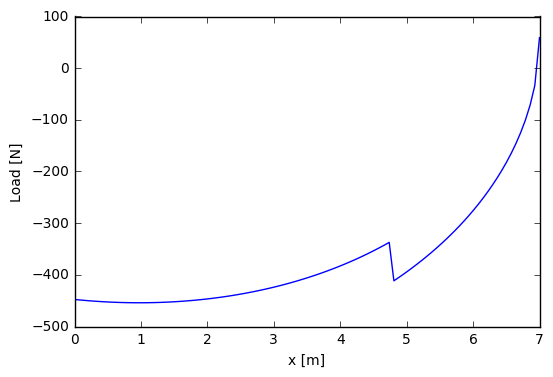

In [20]:
# Add all distributed loads together
wing_load = lift + wing_weight + fuel_weight

# Add point loads, e.g. engines
# [[position1,load1],
# [position2,load2],...]
# Position needs to coincide with a value of x
wing_point_load = np.array([])    # [N]

for i in range(0, wing_point_load.shape[0]):
    j = find_nearest(x, wing_point_load[i, 0])
    wing_load[j] = wing_point_load[i, 1]/dx

# Plot the wing load
plt.plot(x, wing_load)
plt.xlabel('x [m]')
plt.ylabel('Load [N]');

In [21]:
# Second moment of area along wing
moment_area_1 = ((c_wing_t - c_wing_0)/l_wing*x + c_wing_0)*h_wing**3/12
moment_area_2 = ((c_wing_t - c_wing_0)/l_wing*x + c_wing_0 - 2*t_skin) *(h_wing - 2*t_skin)**3/12
moment_area = moment_area_1 - moment_area_2

In [22]:
# Calculate wing deformation
shear, moment, slope, curvature, deflection = calculating_struct(wing_load, x, E, 
                                                                 moment_area, 'cantilever')

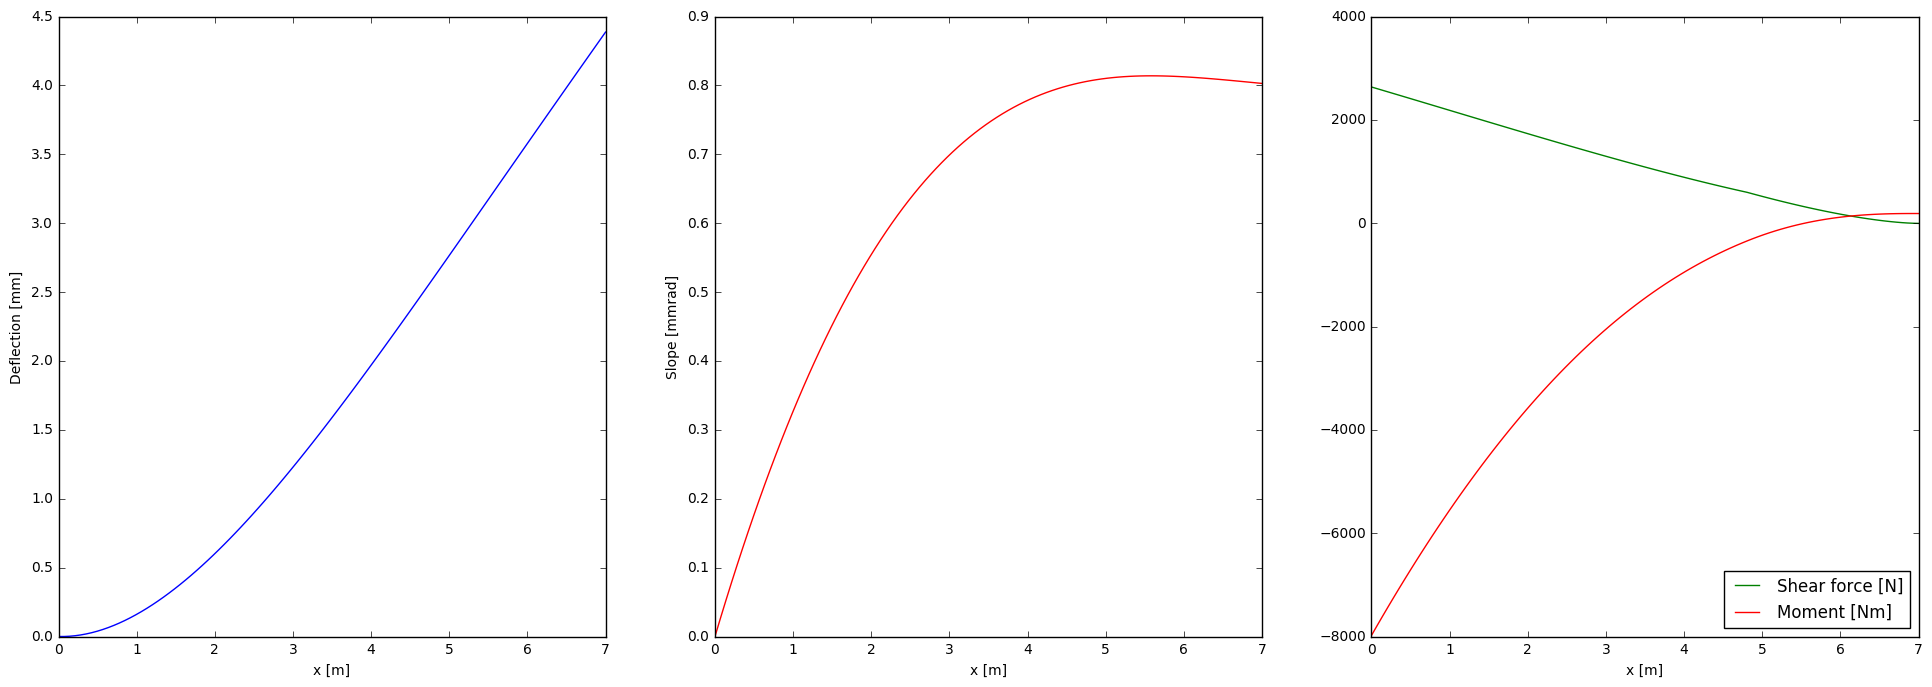

In [23]:
# Initlise the figure and the subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

# Plot the deflection
ax1.plot(x, deflection*1e3)
ax1.set_xlabel('x [m]')
ax1.set_ylabel('Deflection [mm]')

# Plot the slope along the beam
ax2.plot(x, slope*1e3, 'r')
ax2.set_xlabel('x [m]')
ax2.set_ylabel('Slope [mmrad]')

# Plot the shearforce
ax3.plot(x, shear, 'g', label='Shear force [N]')
ax3.plot(x, moment, 'r', label='Moment [Nm]')
ax3.set_xlabel('x [m]')
ax3.legend(loc=4);